# Python Practice Lecture 23 MATH 342W Queens College 
# - Bias-Variance Decomposition
## Author: Amir ElTabakh
## Date: April 28, 2022

## Agenda:
* Background
* Bias - Variance Decomposition of Generalization Error
* Bias - Variance Decomposition of MSE in Regression Trees

## Background

### Bias, Variance, and Irreducible Error

Consider a machine learning model that makes predictions for a predictive modeling task, such as regression or classification.

The performance of the model on the task can be described in terms of the prediction error on all examples not used to train the model. We will refer to this as the model error.

- Error(Model)

The model error can be decomposed into three sources of error: the variance of the model, the bias of the model, and the variance of the irreducible error in the data.

- Error(Model) = Variance(Model) + Bias(Model) + Variance(Irreducible Error)

Let’s take a closer look at each of these three terms.

### Model Bias

The bias is a measure of how close the model can capture the mapping function between inputs and outputs. It captures the rigidity of the model: the strength of the assumption the model has about the functional form of the mapping between inputs and outputs. This reflects how close the functional form of the model can get to the true relationship between the predictors and the outcome.

A model with high bias is helpful when the bias matches the true but unknown underlying mapping function for the predictive modeling problem. Yet, a model with a large bias will be completely useless when the functional form for the problem is mismatched with the assumptions of the model, e.g. assuming a linear relationship for data with a high non-linear relationship.

- Low Bias: Weak assumptions regarding the functional form of the mapping of inputs to outputs.
- High Bias: Strong assumptions regarding the functional form of the mapping of inputs to outputs.

The bias is always positive.

### Model Variance

The variance of the model is the amount the performance of the model changes when it is fit on different training data. It captures the impact of the specifics the data has on the model. Variance refers to the amount by which the model would change if we estimated it using a different training data set. A model with high variance will change a lot with small changes to the training dataset. Conversely, a model with low variance will change little with small or even large changes to the training dataset.

- Low Variance: Small changes to the model with changes to the training dataset.
- High Variance: Large changes to the model with changes to the training dataset.

The variance is always positive.

### Irreducible Error

On the whole, the error of a model consists of reducible error and irreducible error. 

- Model Error = Reducible Error + Irreducible Error

The reducible error is the element that we can improve. It is the quantity that we reduce when the model is learning on a training dataset and we try to get this number as close to zero as possible. The irreducible error is the error that we can not remove with our model, or with any model. The error is caused by elements outside our control, such as statistical noise in the observations and cannot be eliminated by modeling.

As such, although we may be able to squash the reducible error to a very small value close to zero, or even zero in some cases, we will also have some irreducible error. It defines a lower bound in performance on a problem. It is important to keep in mind that the irreducible error will always provide an upper bound on the accuracy of our prediction for Y. This bound is almost always unknown in practice.

No model is perfect.

### Bias-Variance Trade-off
The bias and the variance of a model’s performance are connected.

Ideally, we would prefer a model with low bias and low variance, although in practice, this is very challenging. In fact, this could be described as the goal of applied machine learning for a given predictive modeling problem, Reducing the bias can easily be achieved by increasing the variance. Conversely, reducing the variance can easily be achieved by increasing the bias. This relationship is generally referred to as the bias-variance trade-off. It is a conceptual framework for thinking about how to choose models and model configuration.

This is referred to as a trade-off because it is easy to obtain a method with extremely low bias but high variance, or a method with very low variance but high bias …

We can choose a model based on its bias or variance. Simple models, such as linear regression and logistic regression, generally have a high bias and a low variance. Complex models, such as random forest, generally have a low bias but a high variance.

We may also choose model configurations based on their effect on the bias and variance of the model. The k hyperparameter in k-nearest neighbors controls the bias-variance trade-off. Small values, such as k=1, result in a low bias and a high variance, whereas large k values, such as k=21, result in a high bias and a low variance.

High bias is not always bad, nor is high variance, but they can lead to poor results.

We often must test a suite of different models and model configurations in order to discover what works best for a given dataset. A model with a large bias may be too rigid and underfit the problem. Conversely, a large variance may overfit the problem.

We may decide to increase the bias or the variance as long as it decreases the overall estimate of model error.


## Bias - Variance Decomposition of Generalization Error

Let's try to fit a quadratic $f$ with a linear model and examine bias-variance tradeoff.

In [1]:
# importing dependencies
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Used to download models onto device
import pickle

# Data viz
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette(sns.color_palette("colorblind")) # setting color palette
sns.set(rc={"figure.figsize":(10, 6)}) #width=10, #height=6

In [2]:
# below are custom functions to help us generate visualizations

# importing dependencies
from typing import Sequence, Union
import numpy as np
import matplotlib.pyplot as plt

# function to plot via slope and intercept.
def abline(slope, intercept, color = 'blue'):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color = color)


# functions to plot polynomial expressions
Number = Union[int, float, complex]

def polyval(coefficients: Sequence[Number], x: Sequence[Number]) -> np.ndarray:
    # expand dimensions to allow broadcasting (constant time + inexpensive)
    # axis=-1 allows for arbitrarily shaped x
    x = np.expand_dims(x, axis=-1)
    powers = x ** np.arange(len(coefficients))
    return powers @ coefficients

def polyplot(coefficients: Sequence[Number], x: Sequence[Number], color = 'red', linewidth = 1) -> None:
    y = polyval(coefficients, x)
    plt.plot(x, y, color=color)

In [3]:
# generating data
xmin = 0
xmax = 5
n_train = 20
n_test = 1000
sigma = 1
Nsim = 1000

# function to plot y given x
def quadratic(X):
    y = X**2
    return y

# creating empty matrices to store values (row, column)
training_gs = np.empty((Nsim, 2))
x_trains = np.empty((Nsim, n_train))
y_trains = np.empty((Nsim, n_train))
all_oos_residuals = np.empty((Nsim, n_test))

for nsim in range(Nsim):
    # simulate dataset D_i
    x_train = np.random.uniform(xmin, xmax, n_train)
    delta_train = np.random.normal(0, sigma, n_train)
    y_train = quadratic(x_train) + delta_train
    
    # populating matrices
    x_trains[nsim] = x_train
    y_trains[nsim] = y_train
    
    # fit a model g | x's, delta's and save it
    x_train = pd.DataFrame(x_train.reshape(-1, 1))
    y_train = pd.DataFrame(y_train.reshape(-1, 1))
    g_model_i = LinearRegression(fit_intercept = True).fit(x_train, y_train)
    
    # populating coefficients
    coefficients = [g_model_i.intercept_[0], g_model_i.coef_[0][0]]
    training_gs[nsim] = coefficients
    
    # generate OOS dataset according to the same data generating process (DGP)
    x_test = np.random.uniform(xmin, xmax, n_test)
    delta_test = np.random.normal(0, sigma, n_test)
    y_test = quadratic(x_test) + delta_test
    
    # predict oos using g_model_i and save the oos residual
    x_test = pd.DataFrame(x_test)
    y_hat_test_i = g_model_i.predict(x_test)
    all_oos_residuals[nsim] = y_test - list(y_hat_test_i[:, 0])

Take a look at the irreducible error for one dataset:

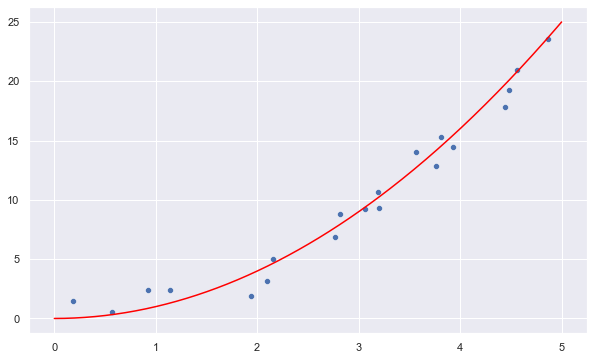

In [4]:
x = x_trains[0]
y = y_trains[0]

sns.scatterplot(x = x, y = y)
polyplot(np.array([0, 0, 1]), np.linspace(0, 5, 300))

There is no way to fit those deviations from the green line using known information. That is the "irreducible error" (from ignorance).

There is dataset to dataset variation in these deltas. Graph a few:

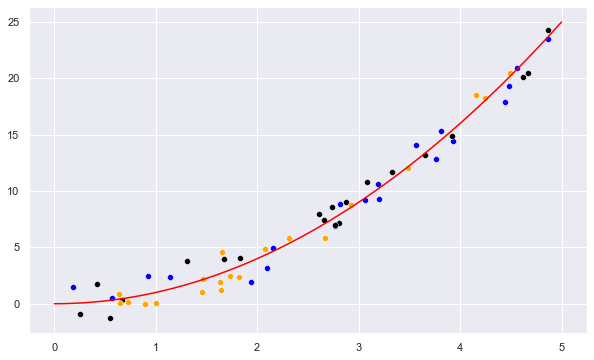

In [5]:
x_0 = x_trains[0]
y_0 = y_trains[0]
sns.scatterplot(x = x_0, y = y_0, color = 'blue')

x_1 = x_trains[1]
y_1 = y_trains[1]
sns.scatterplot(x = x_1, y = y_1, color = 'black')

x_2 = x_trains[2]
y_2 = y_trains[2]
sns.scatterplot(x = x_2, y = y_2, color = 'orange')

polyplot(np.array([0, 0, 1]), np.linspace(0, 5, 300))

The blue dataset is one possible $\mathbb{D}$, the black dataset is another possible $\mathbb{D}$ and the orange dataset is another possible $\mathbb{D}$. This illustrated "dataset-dataset variability".

Take a look at the mse that's averaging over (1) all datasets D and (2) all xstars in the set [0,5]. This should be equal to the three terms: (a) irreducible error plus (b) bias-squared plus (c) variance.

In [6]:
# calculating mse
mse = np.mean(all_oos_residuals ** 2)
mse

5.18095591268775

Let's visualize the bias.

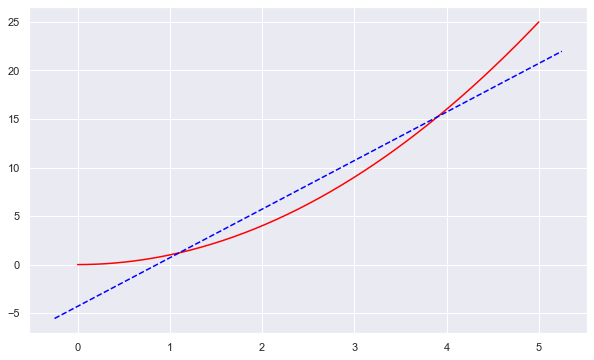

In [7]:
g_average_0 = np.mean(training_gs[:, 0])
g_average_1 = np.mean(training_gs[:, 1])

polyplot(np.array([0, 0, 1]), np.linspace(0, 5, 300))
abline(slope = g_average_1, intercept = g_average_0)

In [8]:
resolution = 10000
x = np.arange(start = xmin, stop = xmax, step = xmax/resolution)
g_avg_x = g_average_0 + g_average_1 * x
f_x = quadratic(x)
biases = f_x - g_avg_x
expe_bias_g_sq = np.mean(biases ** 2)
expe_bias_g_sq

3.48679913195784

What is the variance? Let's look at all lines:

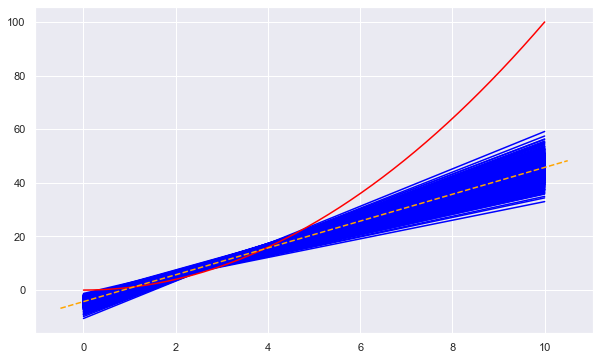

In [9]:
# plot all linear models for all datasets D_i
for intercept, coeffient in training_gs:
    polyplot(np.array([intercept, coeffient]), np.linspace(0, 10, 300), color = 'blue', linewidth = 0.01)

# plot h_star (true model)
polyplot(np.array([0, 0, 1]), np.linspace(0, 10, 300), color = 'red')

# plot average bias
abline(slope = g_average_1, intercept = g_average_0, color = 'orange')

Now calculate this average variance:

In [10]:
resolution = 10000
x = np.arange(start = xmin, stop = xmax, step = xmax/resolution)
expe_g_x = g_average_0 + g_average_1 * x
var_x = np.empty((Nsim))

for nsim in range(Nsim):
    g_x = training_gs[nsim, 0] + training_gs[nsim, 1] * x
    var_x[nsim] = np.mean((g_x - expe_g_x)**2)
    
expe_var_g = np.mean(var_x)
expe_var_g

0.692886618593733

Now check the equivalence:

In [11]:
print(f"MSE: {mse}")
print(f"Standard Dev: {sigma**2}")
print(f"Expected bias: {expe_bias_g_sq}")
print(f"Expected var: {expe_var_g}")
print(f"Calculated MSE: {sigma**2 + expe_bias_g_sq + expe_var_g}")

MSE: 5.18095591268775
Standard Dev: 1
Expected bias: 3.48679913195784
Expected var: 0.692886618593733
Calculated MSE: 5.179685750551573


This is not exactly equal due to numerical error.

Let's try the whole thing again using a quadratic regression!

In [12]:
# creating empty matrices to store values (row, column)
training_gs = np.empty((Nsim, 3))
x_sq_trains = np.empty((Nsim, n_train))
x_trains = np.empty((Nsim, n_train))
y_trains = np.empty((Nsim, n_train))
all_oos_residuals = np.empty((Nsim, n_test))

for nsim in range(Nsim):
    # simulate dataset D_i
    x_train = np.random.uniform(xmin, xmax, n_train)
    x_sq_train = x_train**2
    delta_train = np.random.normal(0, sigma, n_train)
    y_train = quadratic(x_train) + delta_train
    
    # populating matrices
    x_trains[nsim] = x_train
    x_sq_trains[nsim] = x_sq_train
    y_trains[nsim] = y_train
    
    # fit a model g | x's, delta's and save it
    X_train = pd.DataFrame({'x' : x_train.reshape(-1, 1).flatten(),
                            'x_sq': x_sq_train.flatten()})
    y_train = pd.DataFrame(y_train.reshape(-1, 1))
    g_model_i = LinearRegression(fit_intercept = True).fit(X_train, y_train)
    
    # populating coefficients
    coefficients = [g_model_i.intercept_[0], g_model_i.coef_[0][0], g_model_i.coef_[0][1]]
    training_gs[nsim] = coefficients
    
    # generate OOS dataset according to the same data generating process (DGP)
    x_test = np.random.uniform(xmin, xmax, n_test)
    x_sq_test = x_test**2
    X_test = pd.DataFrame({'x' : x_test.reshape(-1, 1).flatten(),
                            'x_sq': x_sq_test.flatten()})
    delta_test = np.random.normal(0, sigma, n_test)
    y_test = quadratic(x_test) + delta_test
    
    # predict oos using g_model_i and save the oos residual
    y_hat_test_i = g_model_i.predict(X_test)
    all_oos_residuals[nsim] = y_test - list(y_hat_test_i[:, 0])

In [13]:
# Take a look at the MSE
mse = np.mean(all_oos_residuals**2)
mse

1.177869097273435

Much lower! Why? Bias went down. 

Let's visualize the bias

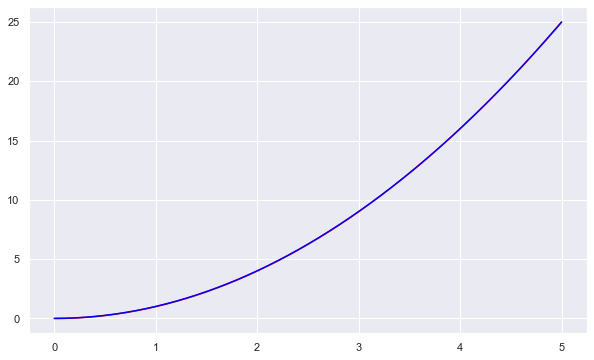

In [14]:
g_average_0 = np.mean(training_gs[:, 0])
g_average_1 = np.mean(training_gs[:, 1])
g_average_2 = np.mean(training_gs[:, 2])

polyplot(np.array([0, 0, 1]), np.linspace(0, 5, 300), color = 'red')
polyplot(np.array([g_average_0, g_average_1, g_average_2]), np.linspace(0, 5, 300), color = 'blue')

Not much bias! Let's output the average weights.

In [15]:
print(f"b_avg_0: {g_average_0}")
print(f"b_avg_1: {g_average_1}")
print(f"b_avg_2: {g_average_2}")

b_avg_0: 0.005145993692607122
b_avg_1: 0.01502758254010142
b_avg_2: 0.9964082568196031


What is the average bias of $g$?

In [16]:
resolution = 10000
x = np.arange(start = xmin, stop = xmax, step = xmax/resolution)
g_avg_x = g_average_0 + g_average_1 * x + g_average_2 * x**2
f_x = quadratic(x)
biases = f_x - g_avg_x
expe_bias_g_sq = np.mean(biases ** 2)
expe_bias_g_sq

0.00022611410686248457

What is the variance? First let's look at all lines:

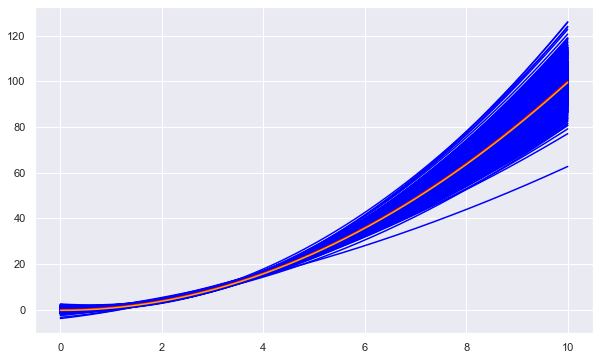

In [17]:
# plot all linear models for all datasets D_i
for intercept, b_1, b_2 in training_gs:
    polyplot(np.array([intercept, b_1, b_2]), np.linspace(0, 10, 300), color = 'blue', linewidth = 0.01)

# plot h_star (true model)
polyplot(np.array([0, 0, 1]), np.linspace(0, 10, 300), color = 'red')

# plot average bias
polyplot(np.array([intercept, g_average_1, g_average_2]), np.linspace(0, 10, 300), color = 'orange')

Let's compute the variance numerically:

In [18]:
resolution = 10000
x = np.arange(start = xmin, stop = xmax, step = xmax/resolution)
expe_g_x = g_average_0 + g_average_1 * x + g_average_2 * x**2
var_x = np.empty((Nsim))

for nsim in range(Nsim):
    g_x = training_gs[nsim, 0] + training_gs[nsim, 1] * x + training_gs[nsim, 2] * x**2
    var_x[nsim] = np.mean((g_x - expe_g_x)**2)
    
expe_var_g = np.mean(var_x)
expe_var_g

0.17818209216896772

Now check the equivalence:

In [19]:
print(f"MSE: {mse}")
print(f"Standard Dev: {sigma**2}")
print(f"Expected bias: {expe_bias_g_sq}")
print(f"Expected var: {expe_var_g}")
print(f"Calculated MSE: {sigma**2 + expe_bias_g_sq + expe_var_g}")

MSE: 1.177869097273435
Standard Dev: 1
Expected bias: 0.00022611410686248457
Expected var: 0.17818209216896772
Calculated MSE: 1.17840820627583


Repeat the process again with quintic polynomials!

In [20]:
# creating empty matrices to store values (row, column)
training_gs = np.empty((Nsim, 6))
all_oos_residuals = np.empty((Nsim, n_test))

for nsim in range(Nsim):
    # simulate dataset D_i
    x_train = np.random.uniform(xmin, xmax, n_train)
    delta_train = np.random.normal(0, sigma, n_train)
    y_train = quadratic(x_train) + delta_train
    
    # fit a model g | x's, delta's and save it
    X_train = pd.DataFrame({'x' : x_train.reshape(-1, 1).flatten(),
                            'x^2': (x_train**2).flatten(),
                            'x^3': (x_train**3).flatten(),
                            'x^4': (x_train**4).flatten(),
                            'x^5': (x_train**5).flatten()})
    y_train = pd.DataFrame(y_train.reshape(-1, 1))
    g_model_i = LinearRegression(fit_intercept = True).fit(X_train, y_train)
    
    # populating coefficients
    coefficients = [g_model_i.intercept_[0], g_model_i.coef_[0][0], # intercept, b1
                    g_model_i.coef_[0][1], g_model_i.coef_[0][2],   # b_2, b_3
                    g_model_i.coef_[0][3], g_model_i.coef_[0][4]]   # b_4, b_5
    training_gs[nsim] = coefficients
    
    # generate OOS dataset according to the same data generating process (DGP)
    x_test = np.random.uniform(xmin, xmax, n_test)
    x_sq_test = x_test**2
    X_test = pd.DataFrame({'x' : x_test.reshape(-1, 1).flatten(),
                           'x^2': (x_test**2).flatten(),
                           'x^3': (x_test**3).flatten(),
                           'x^4': (x_test**4).flatten(),
                           'x^5': (x_test**5).flatten()})
    delta_test = np.random.normal(0, sigma, n_test)
    y_test = quadratic(x_test) + delta_test
    
    # predict oos using g_model_i and save the oos residual
    y_hat_test_i = g_model_i.predict(X_test)
    all_oos_residuals[nsim] = y_test - list(y_hat_test_i[:, 0])

In [21]:
# Take a look at the MSE
mse = np.mean(all_oos_residuals**2)
mse

3.8909836763953978

Much higher! Why? Variance went up!

Let's visualize the bias.

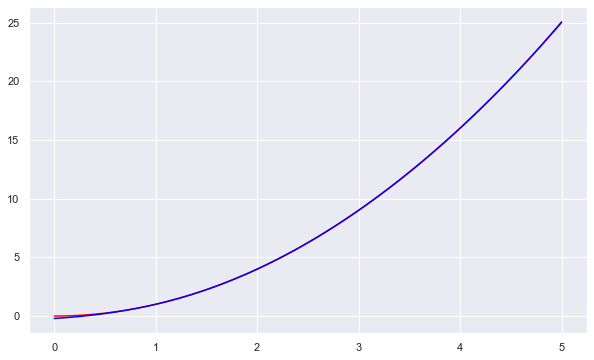

In [22]:
g_average_0 = np.mean(training_gs[:, 0])
g_average_1 = np.mean(training_gs[:, 1])
g_average_2 = np.mean(training_gs[:, 2])
g_average_3 = np.mean(training_gs[:, 3])
g_average_4 = np.mean(training_gs[:, 4])
g_average_5 = np.mean(training_gs[:, 5])

polyplot(np.array([0, 0, 1]), np.linspace(0, 5, 300), color = 'red')
polyplot(np.array([g_average_0, g_average_1, g_average_2,
                   g_average_3, g_average_4, g_average_5]),
         np.linspace(0, 5, 300), color = 'blue')

Not much! Let's output the average weights.

In [23]:
print(f"b_avg_0: {g_average_0}")
print(f"b_avg_1: {g_average_1}")
print(f"b_avg_2: {g_average_2}")
print(f"b_avg_3: {g_average_3}")
print(f"b_avg_4: {g_average_4}")
print(f"b_avg_5: {g_average_5}")

b_avg_0: -0.20516484407893099
b_avg_1: 0.5639941999745743
b_avg_2: 0.45324553709043053
b_avg_3: 0.23864378314860418
b_avg_4: -0.04747918513398634
b_avg_5: 0.0035026085807118336


Now lets compute the average bias squared of $g$:

In [24]:
resolution = 10000
x = np.arange(start = xmin, stop = xmax, step = xmax/resolution)
g_avg_x = g_average_0 + g_average_1 * x + g_average_2 * x**2 + g_average_3 * x**3 + g_average_4 * x**4 + g_average_5 * x**5
f_x = quadratic(x)
biases = f_x - g_avg_x
expe_bias_g_sq = np.mean(biases ** 2)
expe_bias_g_sq

0.001433846167846529

This appears to have increased over last time by a nominal amount ... but it's only because we're not running the regression infinite times. Remember this "expectation" is only an average.

What is the variance? Let's look at all lines:

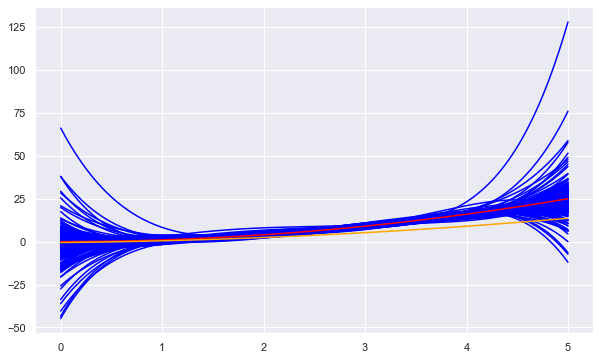

In [25]:
# plot all linear models for all datasets D_i
for intercept, b_1, b_2, b_3, b_4, b_5 in training_gs:
    polyplot(np.array([intercept, b_1, b_2,
                       b_3, b_4, b_5]),
             np.linspace(0, 5, 300), color = 'blue', linewidth = 0.01)

# plot h_star (true model)
polyplot(np.array([0, 0, 1]), np.linspace(0, 5, 300), color = 'red')

# plot average bias
polyplot(np.array([intercept, g_average_1, g_average_2]), np.linspace(0, 5, 300), color = 'orange')

It looks awful!

Now actually compute the average variance numerically:

In [26]:
resolution = 10000
x = np.arange(start = xmin, stop = xmax, step = xmax/resolution)
expe_g_x = g_average_0 + g_average_1 * x + g_average_2 * x**2
var_x = np.empty((Nsim))

for nsim in range(Nsim):
    g_x = training_gs[nsim, 0] + training_gs[nsim, 1] * x + training_gs[nsim, 2] * x**2 +\
            training_gs[nsim, 3] * x**3 + training_gs[nsim, 4] * x**4 + training_gs[nsim, 5] * x**5
    var_x[nsim] = np.mean((g_x - expe_g_x)**2)
    
expe_var_g = np.mean(var_x)
expe_var_g

24.94462591600167

Any more complexity than you need allows for overfitting!

Now check the equivalence

In [27]:
print(f"MSE: {mse}")
print(f"Standard Dev: {sigma**2}")
print(f"Expected bias: {expe_bias_g_sq}")
print(f"Expected var: {expe_var_g}")
print(f"Calculated MSE: {sigma**2 + expe_bias_g_sq + expe_var_g}")

MSE: 3.8909836763953978
Standard Dev: 1
Expected bias: 0.001433846167846529
Expected var: 24.94462591600167
Calculated MSE: 25.946059762169515


## Bias - Variance Decomposition of MSE in Regression Trees

Let's return to the simulated sine curve data which we used to introduce regression trees.

<AxesSubplot:>

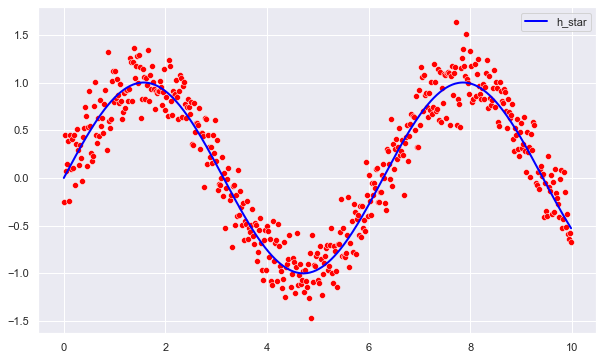

In [28]:
# generating mock dataset

n = 500
xmin = 0
xmax = 10
sigma = 0.2
X = np.arange(start = xmin, stop = xmax, step = xmax/n)
y = np.sin(X) + np.random.normal(0, sigma, n)

# the best possible model
h_star_x = np.sin(X)

# plot x and y as a scatter plot
sns.scatterplot(x = X, y = y, color = 'red')

# plotting the true function in blue
sns.lineplot(x = X, y = h_star_x, label='h_star',
             linewidth = 2, color = 'blue')

Now let's generate lots of different datasets and fit many tree models.

We are going to need the models we generate for later use, so we'll be saving the models onto our local device. This is know as "Pickling" a model. There is no need to install pickle module as it comes already installed along with Python 3.x.

**Note**: Make sure you have a folder called `lec_23_models` where you have this file saved.

In [29]:
# import the regressor
from sklearn.tree import DecisionTreeRegressor
import pickle

# generating data
n = 500
xmin = 0
xmax = 10
sigma = 0.2
n_train = 20
n_test = 1000
Nsim = 1000

# creating empty matrices to store values (row, column)
training_gs = np.empty((Nsim, 2))
all_oos_residuals = np.empty((Nsim, n_test))

for nsim in range(Nsim):
    # simulate dataset D_i
    x_train = np.random.uniform(xmin, xmax, n_train)
    delta_train = np.random.normal(0, sigma, n_train)
    y_train = np.sin(x_train) + delta_train
    
    # fit a model g | x's, delta's and save it
    x_train = pd.DataFrame(x_train.reshape(-1, 1))
    y_train = pd.DataFrame(y_train.reshape(-1, 1))
    # make an instance of the Model
    clf_model_i = DecisionTreeRegressor(random_state = 0, max_depth = 5).fit(x_train, y_train)
    
    # save DecisionTreeRegressor object with pickle
    with open(f'lec_23_models//model_{nsim}.pickle', 'wb') as f:
        pickle.dump(clf_model_i, f)
    
    # generate OOS dataset according to the same data generating process (DGP)
    x_test = np.random.uniform(xmin, xmax, n_test)
    delta_test = np.random.normal(0, sigma, n_test)
    y_test = quadratic(x_test) + delta_test
    
    # predict oos using g_model_i and save the oos residual
    x_test = pd.DataFrame(x_test)
    y_hat_test_i = clf_model_i.predict(x_test)
    all_oos_residuals[nsim] = y_test - list(y_hat_test_i)

What does the storage of all the models look like?

In [30]:
for i in range(0, 20):
    print(round(all_oos_residuals[0][i], 7))

0.4777215
91.6953259
1.7547752
96.881924
26.8985114
26.4849422
56.4572478
9.7150129
50.497457
11.1692557
45.2116301
96.7779893
-0.0143362
98.5984141
52.9024633
-0.1832451
-0.4410606
3.957577
-0.1990648
87.5771495


In [31]:
mean_residuals_all_models = np.empty((len(all_oos_residuals), 1))
for i in range(len(all_oos_residuals)):
    mean_residuals_all_models[i] = np.mean(all_oos_residuals[i])
    
mse = np.mean(mean_residuals_all_models)
print(np.mean(mean_residuals_all_models))

33.101244346621826


Take a look at the mse:

In [32]:
# Take a look at the MSE
mean_residuals_all_models = np.empty((len(all_oos_residuals), 1))
for i in range(len(all_oos_residuals)):
    mean_residuals_all_models[i] = np.mean(all_oos_residuals[i])
    
mse = np.mean(mean_residuals_all_models)
mse

33.101244346621826

Let's visualize the bias:

<AxesSubplot:>

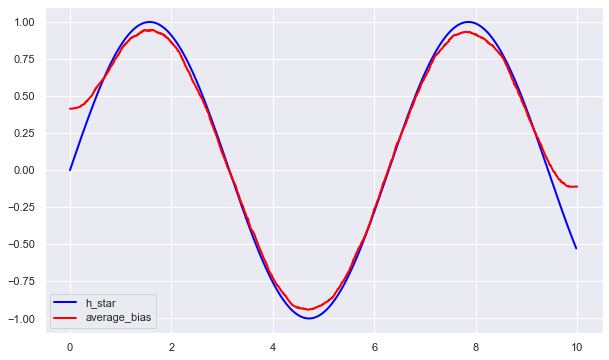

In [33]:
resolution = 10000
x = pd.DataFrame(np.arange(start = xmin, stop = xmax, step = xmax/resolution))
f_x = np.sin(x)
g_avg_x = np.zeros(resolution, dtype = float)

for nsim in range(Nsim):
    with open(f'lec_23_models//model_{nsim}.pickle', 'rb') as f:
        clf = pickle.load(f)
    g_avg_x = g_avg_x + clf.predict(x)

g_avg_x = g_avg_x / Nsim
g_avg_x

# plotting the true function in blue
sns.lineplot(x = X, y = h_star_x, label='h_star',
             linewidth = 2, color = 'blue')

# plotting the average bias in red
x = pd.Series(np.arange(start = xmin, stop = xmax, step = xmax/resolution))
sns.lineplot(x = x, y = pd.Series(g_avg_x), label='average_bias',
             linewidth = 2, color = 'red')

Not much! Now actually compute the average bias squared of $g$:

In [34]:
biases = f_x - pd.DataFrame(g_avg_x)
expected_bias_g = np.mean(biases**2)
expected_bias_g

0    0.007562
dtype: float64

This is small - why??

It's because trees are so expressive and have such model complexity that they can nail almost any true $f$ function!

That means the MSE save the irreducible noise is coming from the variance. Let's look at the variance vs f(x):

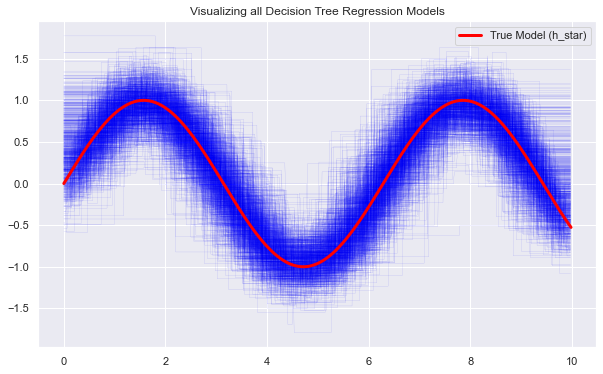

In [35]:
X_grid = np.arange(min(X), max(X), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1)) 

  
# plot predicted data
for nsim in range(Nsim):
    with open(f'lec_23_models//model_{nsim}.pickle', 'rb') as f:
        clf = pickle.load(f)
    plt.plot(X_grid, clf.predict(X_grid), color = 'blue', linewidth = 0.1, alpha = 0.6) 

# specify title
plt.title('Visualizing all Decision Tree Regression Models') 

# plotting the true function in blue
sns.lineplot(x = X, y = h_star_x, label='True Model (h_star)',
             linewidth = 3, color = 'red')

# show the plot
plt.show()

It looks awful! Let's observe 50 lines so the graph is more comprehensible.

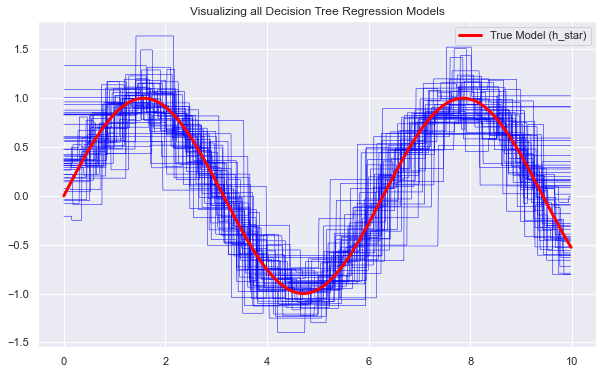

In [36]:
X_grid = np.arange(min(X), max(X), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1)) 

  
# plot predicted data
for nsim in range(50):
    with open(f'lec_23_models//model_{nsim}.pickle', 'rb') as f:
        clf = pickle.load(f)
    plt.plot(X_grid, clf.predict(X_grid), color = 'blue', linewidth = 0.5) 

# specify title
plt.title('Visualizing all Decision Tree Regression Models') 

# plotting the true function in blue
sns.lineplot(x = X, y = h_star_x, label='True Model (h_star)',
             linewidth = 3, color = 'red')

# show the plot
plt.show()

Now actually compute the average variance numerically:

In [37]:
resolution = 10000
x = pd.DataFrame(np.arange(start = xmin, stop = xmax, step = xmax/resolution))
f_x = np.sin(x)
g_var_avg_x = np.zeros(resolution, dtype = float)

for nsim in range(Nsim):
    with open(f'lec_23_models//model_{nsim}.pickle', 'rb') as f:
        clf = pickle.load(f)
    g_x = clf.predict(x)
    g_var_avg_x[nsim] = np.mean((g_x - g_avg_x)**2)

expected_var_g = np.mean(g_var_avg_x)
expected_var_g

0.009143871370432485

Any more complexity than you need allows for overfitting!

Now check the equivalence

In [38]:
print(f"MSE: {mse}")
print(f"Standard Dev: {sigma**2}")
print(f"Expected bias: {expected_bias_g[0]}")
print(f"Expected var: {expected_var_g}")
print(f"Calculated MSE: {sigma**2 + expected_bias_g[0] + expected_var_g}")

MSE: 33.101244346621826
Standard Dev: 0.04000000000000001
Expected bias: 0.007562281847958557
Expected var: 0.009143871370432485
Calculated MSE: 0.05670615321839105
